# General Overview

#### In this project, I'll be exploring whether one can beat the S&P 500 (Standard & Poor’s 500 Index) — the most widely-used benchmark for the overall U.S. stock market — by leveraging a simple momentum strategy. Specifically, I simulate investing in the top-performing S&P 500 stocks at regular intervals and compare the resulting portfolio performance against traditional benchmarks like SPY (Common S&P 500 Index), QQQ (The Nasdaq ETF), and Berkshire Hathaway (If we can beat Warren Buffet!!).

#### This will start in the year 2000, because the QQQ starts in 1999 and I'd like to get comparisons. The data ends at the end of 2021 because that is when the data I downloaded stops

### Sections:
- **Introduction** – Brief overview of momentum investing and how the data was sourced  
- **Data Preprocessing** – Explanation of the local processing done (on my local computer) to comply with the 20MB upload limit  
- **Top-N Selection** – Function to extract the top-performing stocks over time  
- **Strategy Simulation** – Monthly investment simulation in top-performing stocks  
- **Visualization** – Graphs showing how the portfolio evolves over time  
- **Adjusting the strategy to SPY, QQQ, and BRK.A** - Adjusting the strategy simulation to match for the ETFs in order to compare them later on
- **Benchmark Comparison** – Comparing the strategy to SPY, QQQ, and BRK.B  
- **Conclusion** – Summary of results and takeaways  


#### All raw data was downloaded from the following website: https://www.kaggle.com/datasets/paultimothymooney/stock-market-data

### Introduction: What is Momentum?

The reason for my doing this analysis, is that I hear people oftentimes say, "I wish I would've invested in Apple, or Google, or Amazon 10 years ago". Theoretically, with this momentum strategy, you're not going to be missing those big stocks. Momentum is the idea that when a stock 'gets hot', or starts to move up drastically, that it will continue to do so - at least in the short to medium future (read: months to a few years). Meaning those big jumps for amazon, apple, and google - you wouldn't have caught it super early, but you wouldn't have been late. 

This project aims to find out if we would've actually managed to 'hit' on those stocks. If we can grab the N (10 for instance) top stocks per month, would these 1000X'ers be in them? where would we catch them in their wave? and can we outperform the SP500 or the oracle from omaha? All those questions will hopefully be answered in this small and fun analysis.

### Data Preprocessing

Because of Vocareum’s 20MB file size upload limit, I couldn’t include the full dataset I originally used. In fact, it was all in seperate csv files from various stocks, which I ended up merging, preprocessing, and pivoting, before uploading the result of that pivot here. 

In the link in the first paragraph, you can find all the data that I downloaded, and I'll include my preprocessing code (commented out) in order for the reader to attempt this, or similar analysis, themeselves. From here on out, we'll be using the clean dataset after my preprocessing.


In [1]:
import pandas as pd
import os
import numpy as np
import math
from collections import defaultdict


In [2]:
# Merging all the csv files together 

# # Path to the folder containing the CSV files
# folder_path = r"your folder you downloaded the csv files to"

# dataframes = []

# # Iterate over each file in the folder
# for filename in os.listdir(folder_path):
#     if filename.endswith('.csv'):
#         # Extract the ticker symbol from the filename (removing the .csv extension)
#         ticker = filename.replace('.csv', '')
        
#         # Read the CSV file into a dataframe
#         df = pd.read_csv(os.path.join(folder_path, filename))
        
#         # Add the ticker symbol column
#         df['Ticker'] = ticker
        
#         # Append the dataframe to the list
#         dataframes.append(df)

# # Merge them all together to form a master dataframe
# mega_dataframe = pd.concat(dataframes, ignore_index=True)

In [3]:
# Keeping only the Date, Close price (daily), and Ticker symbols
# mega_dataframe = mega_dataframe[['Date','Close', 'Ticker']]

In [4]:
# Here we're pivoting the dataframe to have the index be the date, the columns the stock ticker,and the price at the date as values
# flattened_dataframe = mega_dataframe.pivot(index='Date', columns='Ticker', values='Close')

In [5]:
# Here I sent to parquet file in order to uploaded, and re-used here
# flattened_dataframe.to_parquet("pivoted_sp500_all.parquet")

**And now we're finally to the point where can start the analysis. I'll post the final dataframe here below, and peform a little more preprocessing here**

In [6]:
flattened_dataframe = pd.read_parquet("pivoted_sp500_all.parquet")
flattened_dataframe.head(3)

Ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.100822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.102319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.102569,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**As you can see, most of the data early on is not available, and as such we'll move the analysis up to the end of year 1999, which will make the data a lot more usable. We choose end of 1999 because later one we'll need to remove the first month to get percent changes and I want this analysis to include january of 2000**

**Additionally, we'll also skip every 21 rows because there are roughly 22 trading days in a month (on average) and as such this will give us even spacing without dealing with datetime issues by choosing the first trading day of each month. I've done that before, and I cannot promise that vocareum can deal with it so we'll do this simplified approach**

In [7]:
filtered_dataframe = flattened_dataframe[flattened_dataframe.index >= '1999-12-02']
filtered_dataframe = filtered_dataframe.iloc[::21, :]

In [8]:
filtered_dataframe.head(3)

Ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-02,27.053013,NaN,NaN,0.841181,NaN,2.350354,15.500,10.036410,NaN,17.028511,...,NaN,7.783124,20.408319,6.649212,NaN,5.218657,NaN,25.555555,45.736156,NaN
2000-01-03,44.143147,NaN,NaN,0.854541,NaN,3.016692,18.250,9.347845,NaN,16.274672,...,NaN,7.392478,19.472013,6.828165,NaN,4.837794,NaN,25.027779,38.532940,NaN
2000-02-02,46.902100,NaN,NaN,0.754343,NaN,3.658799,28.125,8.873784,NaN,15.219688,...,NaN,7.416794,20.839567,7.500085,NaN,3.751923,NaN,26.263889,40.924149,NaN


### Top N Selection

This function will need to parts to it.

**Part 1** – We’ll calculate the monthly percent change for each stock in our dataset.  
**Part 2** – Using that percent change data, we’ll identify the top N (default: 10) best-performing stocks for each month.

The goal here is to clearly define what we mean by “top-performing stocks.” By showing how the top stocks are selected based on monthly returns, we set the stage for the momentum-based strategy that follows.

In [9]:
# Calculate the top N performing Stocks for each date in the dataframe based on percentage change

def get_top_n_performers(df, n=10):
    
    # Part 1
    percentage_changes = df.pct_change()
    
    # Part 2
    results = []

    for idx, row in percentage_changes.iterrows():
        if idx == df.index[0]:  # skip first row (no previous data)
            continue
        
        top_n_changes = row.nlargest(n).index
        
        for ticker in top_n_changes:
            results.append({
                'Date': idx,
                'Ticker': ticker,
                'Pct_Change': row[ticker],
                'Price': df.at[idx, ticker]
            })

    return pd.DataFrame(results)


top_N_changes_df = get_top_n_performers(filtered_dataframe, n=10)

In [10]:
top_N_changes_df.head(3)

,Date,Ticker,Pct_Change,Price
0,2000-01-03,INCY,1.570789,44.828125
1,2000-01-03,VRSN,0.951877,161.444855
2,2000-01-03,QCOM,0.917780,60.164860


### Strategy Simulation

Now that we’ve figured out how to identify the top N performing stocks for each month, it’s time to simulate what would happen if we invested in them instead of the ETF's.

The simulation assumes:
- Every month, we invest X amount into each of the top N stocks (e.g., top 10). I'll be using 100 dollars as the default since having 1000 left over each month is reasonable and realistic for many people.
- We track the number of shares we own over time.
- At the end of each month, we evaluate the total portfolio value based on the prices of all stocks currently held.

Note: In general this can be done without using dollars, but rather percent changes. I personally find it easier to imagine and debug with something more tangible. we can always convert to percent changes later


In [11]:
def simulate_momentum_strategy(price_df, n=10, investment_per_stock=100):

    top_n_df = get_top_n_performers(price_df, n)

    shares_held = defaultdict(float)
    portfolio_history = []

    # Simulate monthly investments
    # 1. grab the unique date in each buying time
    # 2. for each one, grab the ticker and the price for every stock on that buy date
    # 3. add to the shares_held dictionary
    # 4. grab the data for all the stocks at each particular month
    # 5. add them to the portfolio history
    
    for date in sorted(top_n_df['Date'].unique()):
        month_df = top_n_df[top_n_df['Date'] == date]

        # Add the ticker and price and amount bought to the shares_held dict
        for _, row in month_df.iterrows():
            ticker = row['Ticker']
            price = row['Price']
            if price > 0:
                raw_shares = investment_per_stock / price
                rounded_shares = math.floor(raw_shares * 100) / 100  # round down to 2 decimal places since we don't want 10.123124235234234 stocks...
                shares_held[ticker] += rounded_shares

        # Calculate portfolio value on this date
        if date in price_df.index:
            current_prices = price_df.loc[date]
            total_value = sum(
                shares_held[ticker] * current_prices.get(ticker, 0)
                for ticker in shares_held
            )
            portfolio_history.append({'Date': date, 'Value': total_value})

    return pd.DataFrame(portfolio_history)


In [12]:
Momentum_Portfolio = simulate_momentum_strategy(filtered_dataframe, n=10, investment_per_stock=100)

In [13]:
Momentum_Portfolio.head(3)

,Date,Value
0,2000-01-03,997.312460
1,2000-02-02,2053.446609
2,2000-03-03,4058.953854


### Strategy Performance Visualization

To better understand how our strategy performs over time, we'll be looking at the graph of our portfolio first. we can then later re-use this code for visualization when comparing to the SP500, QQQ, and BRK.A ETF's

For visualizations of this nature I prefer bokeh over matplotlib because bokey allows zooming in, scrolling, and various other features which is very useful when doing analysis on stocks and strategies 

Note - I took this from another analysis I did a while back, and it's probably done with chatgpt or from a youtube video. I'll document what everything means but just know that this is just a code for visualization i personally have saved and re-use when doing these types of analysis.


In [14]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource

# Only needed once in the notebook, and tells the bokeh to open inside the jupyter notebook
output_notebook()

# Ensure 'Date' is datetime
Momentum_Portfolio['Date'] = pd.to_datetime(Momentum_Portfolio['Date'])

# Set up data source
source = ColumnDataSource(data={
    'date': Momentum_Portfolio['Date'],
    'value': Momentum_Portfolio['Value']
})

# Create figure
# Pan, wheel_zoom, reset, and save are just as they sound. Hover allows you to hover over points to see their values

p = figure(x_axis_type='datetime', title='Portfolio Value Over Time',
           plot_height=400, plot_width=800, tools='pan,wheel_zoom,reset,hover,save')

p.line('date', 'value', source=source, line_width=2, color='navy', legend_label="Top N Strategy")
p.circle('date', 'value', source=source, size=5, color='navy', alpha=0.3)

# Customize hover - just formatting it so when you hover it displays the proper data

hover = p.select(dict(type=HoverTool))
hover.tooltips = [("Date", "@date{%F}"), ("Value", "@value{$0,0.00}")]
hover.formatters = {"@date": "datetime"}


p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Portfolio Value ($)'
p.legend.location = 'top_left'

# Show plot
show(p)


Loading BokehJS ...

**Note on this analysis. What do we see here?**
we can see that we have invested a total of (270 months x 1000 dollars)  270,000 dollars total. we finished with 3 million, and with a peak of nearly 4.5 million usd. using the compounding annual growth rate formula, we can estimate that this is equivilant to making 12.35% per year. if we 'ignored' the last 6 months which was the downturn (which isn't the right thing to do, but just to put this into perspective) this is equivilant to 13.66% per year. we'll see later what the market did during that time period.


The sharp fall at the end is due to the market crash of 2022 by the way. 

### Adjusting the Strategy to SPY, QQQ, BRK.A

This entire concept was done to ask, "can we beat the market with this strategy". These 3 Funds are funds that are widely invested and if we can beat them, then this is an incredibly viable strategy. To do so, however, we need the data for these funds, and then we can create a simpler simulation in order to get the same prices, on the same dates, if we invested 1000 a month (10 Stocks x 100 dollars) what the value will be. 

Firstly, I'll add in some code for you to copy to your local computer so you can also download the data. I prefer to use alphavantage because yfinance has some API restrictions which I don't like dealing with. To be able to download from alphavantage you need to get a **free** API key from https://www.alphavantage.co/support/#api-key and then you can just use the code i'll add below (commented out again) in order to download the data for any stocks or funds you want. I've of course loaded the csv's onto vocareum so we can just call the data here and then adjust it. 

This download data is something I've used for years. It's not completely original, I believe I took the first half from stack_overflow a few years ago but I'm not entirely sure to be honest. I've commented on it for my own use previously

In [15]:
# import requests
# import json
# import pandas as pd
# import time

# def fetch_daily_data(symbol, api_key):
#     url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize=full"
#     response = requests.get(url)
#     if response.status_code == 200:
#         data = json.loads(response.text)
#         if "Time Series (Daily)" in data:
#             df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient='index')
#             # Optionally convert the index to a datetime format
#             df.index = pd.to_datetime(df.index)
#             # Optionally sort the DataFrame by date (index)
#             df = df.sort_index()
#             return df
#         else:
#             print(f"Could not fetch data for {symbol}: {data.get('Note', 'Unknown error')}")
#             return None
#     else:
#         print(f"Failed to fetch data for {symbol}: {response.status_code}")
#         return None

# # Your API key
# api_key = 'YOUR_API_KEY'  # Replace YOUR_API_KEY_HERE with your actual API key

# symbols = ['SPY', 'QQQ', "BRK.A"]

# # Initialize an empty dictionary to hold data for both symbols
# all_data = {}

# # Fetch daily data for each symbol and store in the dictionary
# for symbol in symbols:
#     print(f"Fetching daily data for {symbol}...")
#     df = fetch_daily_data(symbol, api_key)
#     if df is not None:
#         all_data[symbol] = df
#     time.sleep(12)  # Sleep to avoid hitting API rate limits, adjust as needed based on your API key's limitations
    
# for symbol, df in all_data.items():
#     csv_filename = f"{symbol}_daily_data.csv"
#     df.to_csv(csv_filename)
#     print(f"Saved {symbol} data to {csv_filename}")


**And now to work on the strategy **

We need to import the files first, and then adjust the data with some pandas processing in order to have it match the previous data. We need to have date cut-offs, grab the closing values only, and then we can simulate buying every month. thankfully this simulation is much simpler, as you'll see

In [16]:
SPY_df = pd.read_csv('SPY_daily_data.csv')
QQQ_df = pd.read_csv('QQQ_daily_data.csv')
BRK_df = pd.read_csv('BRK.A_daily_data.csv')

In [17]:
#just to see how it looks. they'll all have the same format though
QQQ_df.head(1)

,Unnamed: 0,1. open,2. high,3. low,4. close,5. volume
0,1999-11-01,131.5,133.1,130.6,130.8,4840900


**Let's Clean up this dataframe to something we can understand**
we're renaming the unnamed column to date, and kepeing only the close column which is the price at close 

In [18]:
def clean_alpha_vantage_df(df):

    df = df.rename(columns={'Unnamed: 0': 'Date', '4. close': 'Close'})
    df = df[['Date', 'Close']]
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [19]:
SPY = clean_alpha_vantage_df(SPY_df)
QQQ = clean_alpha_vantage_df(QQQ_df)
BRK = clean_alpha_vantage_df(BRK_df)
SPY.head(1)

,Date,Close
0,1999-11-01,135.5625


**Nowe we can perform the strategy to get a simulated portfolio for each of the funds**

The steps to create this are
1. we need to make sure the dates match up with our strategy dates. meaning we keep only the dates that are in our original strategy.

2. we will create a new column which is simply amount bought each month

3. we will create another column which is the cumulative sum for each month

4. we will create a last column which is cumsum x close which is the value of portfolio at that time.

As you can see this is much simpler, and most of these steps are simple pandas one-liners

In [20]:
# Benchmark_df is the SPY or QQQ or other fund you want to check

def simulate_simple_strategy(benchmark_df, portfolio_df, monthly_investment=1000):

    # Align dates - Step 1
    benchmark_df['Date'] = pd.to_datetime(benchmark_df['Date'])
    portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'])
    df = benchmark_df[benchmark_df['Date'].isin(portfolio_df['Date'])].copy()
    df = df.reset_index(drop=True)


    # Step 2
    df['Shares_Bought'] = monthly_investment/ df['Close']
    
#     Step 3
    df['Cumulative_Shares'] = df['Shares_Bought'].cumsum()

#     Step 4
    df['Portfolio_Value'] = df['Cumulative_Shares'] * df['Close']

    return df

In [21]:
SPY_strategy = simulate_simple_strategy(SPY, Momentum_Portfolio, monthly_investment=1000)
QQQ_strategy = simulate_simple_strategy(QQQ, Momentum_Portfolio, monthly_investment=1000)
BRK_strategy = simulate_simple_strategy(BRK, Momentum_Portfolio, monthly_investment=1000)

In [22]:
SPY_strategy.head(3)

,Date,Close,Shares_Bought,Cumulative_Shares,Portfolio_Value
0,2000-01-03,145.4375,6.875806,6.875806,1000.000000
1,2000-02-02,141.0625,7.089056,13.964862,1969.918350
2,2000-03-03,141.1250,7.085917,21.050779,2970.791154


### Benchmark Comparisons

We're now going to be graphing and comparing our momentum strategy against our benchmark funds. We'll be recycling the code from the visualizations earlier, and then we can view them all side by side. we can talk about findings after the visualizations in the conclusion section

I ended up changing the momentum portfolio 'value' from value to portfolio value because it allowed me to cut down on the hove_tooltips part and just merge that for all of them.

In [23]:
output_notebook()

p = figure(x_axis_type='datetime', title='Portfolio Value Comparison',
           plot_width=900, plot_height=450, tools='pan,wheel_zoom,box_zoom,reset,hover,save')

# Define the sources
momentum_source = ColumnDataSource(Momentum_Portfolio.rename(columns={'Value': 'Portfolio_Value'}))
spy_source = ColumnDataSource(SPY_strategy)
qqq_source = ColumnDataSource(QQQ_strategy)
brk_source = ColumnDataSource(BRK_strategy)

# Plot each line individually
p.line('Date', 'Portfolio_Value', source=momentum_source, line_width=2, color='navy', legend_label='Momentum Strategy')
p.line('Date', 'Portfolio_Value', source=spy_source, line_width=2, color='green', legend_label='SPY')
p.line('Date', 'Portfolio_Value', source=qqq_source, line_width=2, color='orange', legend_label='QQQ')
p.line('Date', 'Portfolio_Value', source=brk_source, line_width=2, color='maroon', legend_label='Berkshire Hathaway')

# Hover tool (applies to all)
hover = p.select_one(HoverTool)
hover.tooltips = [("Date", "@Date{%F}"), ("Value", "@Portfolio_Value{$0,0.00}")]
hover.formatters = {"@Date": "datetime"}

# Labels and legend
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Portfolio Value ($)'
p.legend.location = 'top_left'
p.legend.click_policy = "mute"

# Show the plot
show(p)


Loading BokehJS ...

In [24]:
print("Momentum:", round((Momentum_Portfolio['Value'].max() - Momentum_Portfolio['Value'].iloc[-1]) / Momentum_Portfolio['Value'].max() * 100, 2), "%")
print("SPY:", round((SPY_strategy['Portfolio_Value'].max() - SPY_strategy['Portfolio_Value'].iloc[-1]) / SPY_strategy['Portfolio_Value'].max() * 100, 2), "%")
print("QQQ:", round((QQQ_strategy['Portfolio_Value'].max() - QQQ_strategy['Portfolio_Value'].iloc[-1]) / QQQ_strategy['Portfolio_Value'].max() * 100, 2), "%")
print("Berkshire:", round((BRK_strategy['Portfolio_Value'].max() - BRK_strategy['Portfolio_Value'].iloc[-1]) / BRK_strategy['Portfolio_Value'].max() * 100, 2), "%")

Momentum: 31.7 %
SPY: 20.09 %
QQQ: 29.38 %
Berkshire: 19.9 %


### Conclusion and Discussion

**What can we see?** - From the chart it is pretty obvious that *yes, we beat the market!!!*. 
This is good news, but this honestly requires a bit more deeper analysis before I'd personally feel comfortable investing in it. At the end after the graph I included a quick calculation for the drawdown percentage at the end of the year (the start of the 2022 down-market). We can see that because we *aren't* super diversified, then we're hit with a harder downturn than SPY. What's surprising to me personally, is that QQQ is not far off from our strategy. 

To be sure of this strategy, I would check it on various other intervals, for instance I would go from right before the '08 crash until right after the '22 crash, so that about a third of our time is spent in a 'bear' (or, down) market. I would also check with 20 stocks, 30 stocks, and 50 stocks, to see if there's a trend. We can use various finance formulas that use drawdown, risk, and other metrics to determine which would be the better strategy. 

Additionally, I would personally perform another analysis on this same dataset that would check if there's a point at which growth stagnates for stocks. Does it happen after a few years? does it happen after a specific amount of percentage points? If we take profits from those and then re-diversify into Gold or Berkshire, will that outperform? There's a lot more to mess around with here, and feel free to take my code, and play around with different values! 

Thank you for spending the time to read my sleep-deprived rants.

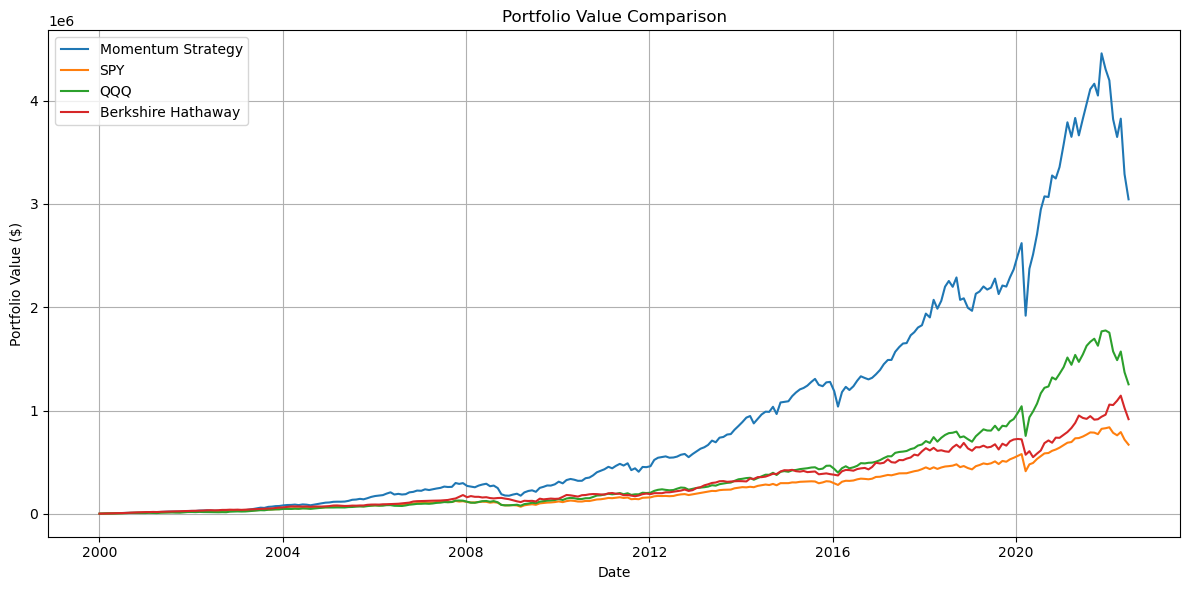

In [25]:
# For printing
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(Momentum_Portfolio['Date'], Momentum_Portfolio['Value'], label='Momentum Strategy')
plt.plot(SPY_strategy['Date'], SPY_strategy['Portfolio_Value'], label='SPY')
plt.plot(QQQ_strategy['Date'], QQQ_strategy['Portfolio_Value'], label='QQQ')
plt.plot(BRK_strategy['Date'], BRK_strategy['Portfolio_Value'], label='Berkshire Hathaway')

plt.title('Portfolio Value Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("comparison_static.png", dpi=300)  # Save for LaTeX or PDF
plt.show()
